# HW Research Seminar. Variant 2. Task 2.

* Alexey Timchenko
* Alexander Kovalev
* Anna Makarova
* Asma Benashour

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import warnings

seaborn.set(context='notebook', style='ticks', palette='bright', )

## Task 2

### Hodgkin-Huxley Model

> Izhikevich pdf page 48

#### 1. Parameters alpha, beta and C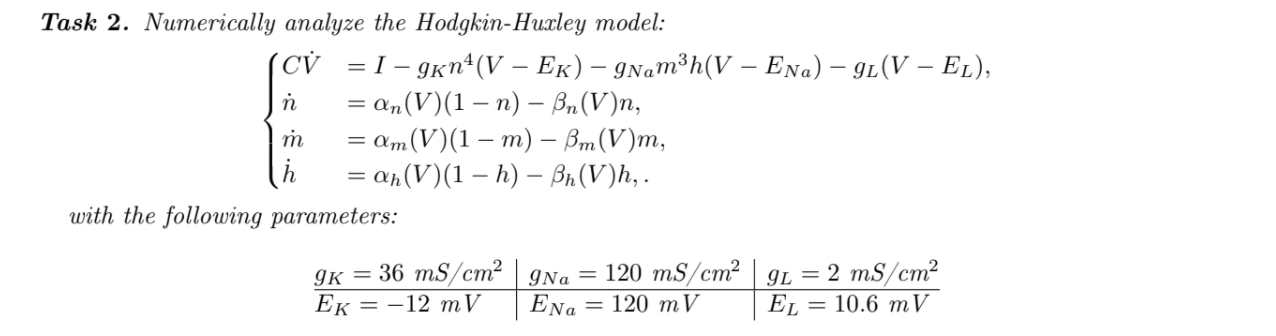

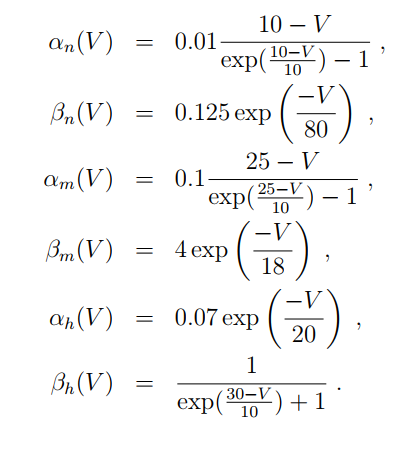

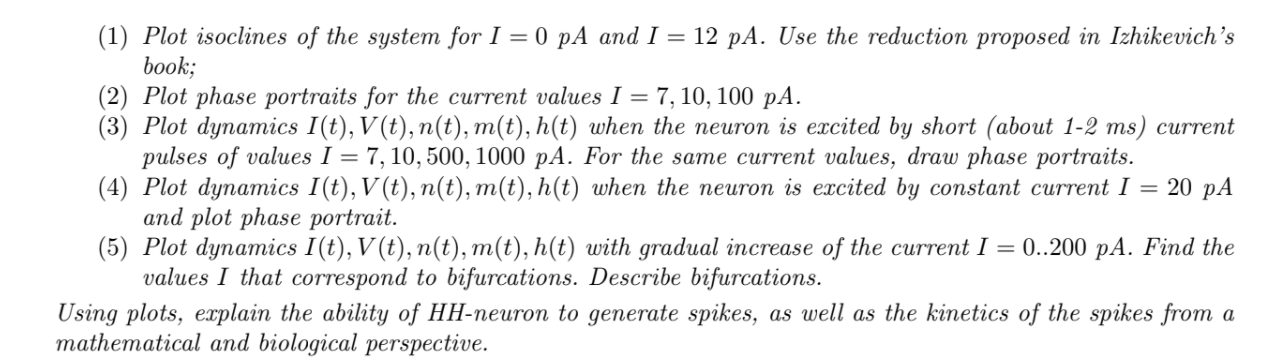

- (1) - DO NOT KNOW (IF reduction leaves us with 1-D V(t), then isoclines are just dots in (V, dV/dt) phase portraits
- (2) - Can only plot phase-trajectories
- (3) - 1st part ok, 2nd part - phase-trajectories
- (4) - Ok (again phase-portrait problem)
- (5) - Ok, no description of bifurcations

In [2]:
def alpha_n(V):
    return 0.01 * (10 - V) / (np.exp((10 - V)/10) - 1)
    
def beta_n(V):
    return 0.125 * np.exp(-V/80)

def alpha_m(V):
    return 0.1 * (25 - V) / (np.exp((25 - V)/10) - 1)

def beta_m(V):
    return 4 * np.exp(-V/18)

def alpha_h(V):
    return 0.07 * np.exp(-V/20)

def beta_h(V):
    return 1/(np.exp((30 - V)/10) + 1)


In [3]:
def n_inf(V):
    return alpha_n(V)/(alpha_n(V) + beta_n(V))

def m_inf(V):
    return alpha_m(V)/(alpha_m(V) + beta_m(V))

def h_inf(V):
    return alpha_h(V)/(alpha_h(V) + beta_h(V))

def tau_n(V):
    return 1/(alpha_n(V) + beta_n(V))

def tau_m(V):
    return 1/(alpha_m(V) + beta_m(V))

def tau_h(V):
    return 1/(alpha_h(V) + beta_h(V))

#### 1. Testing (in)activation functions to acquire their value at t0

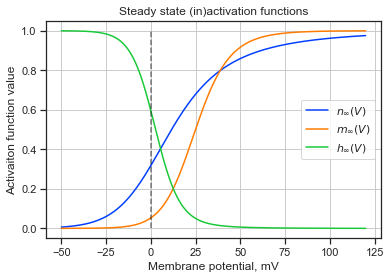

In [126]:
V = np.linspace(-50, 120, 300) 

plt.title("Steady state (in)activation functions")
plt.plot(V, n_inf(V), label=r"$n_\infty(V)$")
plt.plot(V, m_inf(V), label=r"$m_\infty(V)$")
plt.plot(V, h_inf(V), label=r"$h_\infty(V)$")
plt.xlabel("Membrane potential, mV")
plt.ylabel("Activaiton function value")
plt.vlines(0, 0, 1, color='black', linestyles='dashed', alpha=0.5)
plt.grid()
plt.legend()
plt.savefig("figures/activation_functions.pdf")
plt.show()

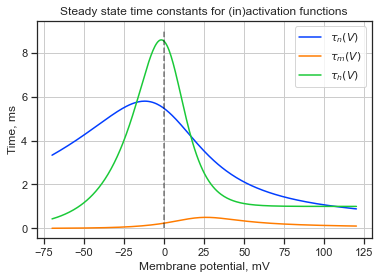

In [127]:
V = np.linspace(-70, 120, 300) 

plt.title("Steady state time constants for (in)activation functions")
plt.plot(V, tau_n(V), label=r"$\tau_n(V)$")
plt.plot(V, tau_m(V), label=r"$\tau_m(V)$")
plt.plot(V, tau_h(V), label=r"$\tau_h(V)$")
plt.xlabel("Membrane potential, mV")
plt.ylabel("Time, ms")
plt.vlines(0, 0, 9, color='black', linestyles='dashed', alpha=0.5)
plt.grid()
plt.legend()
plt.savefig("figures/time_constants.pdf")
plt.show()


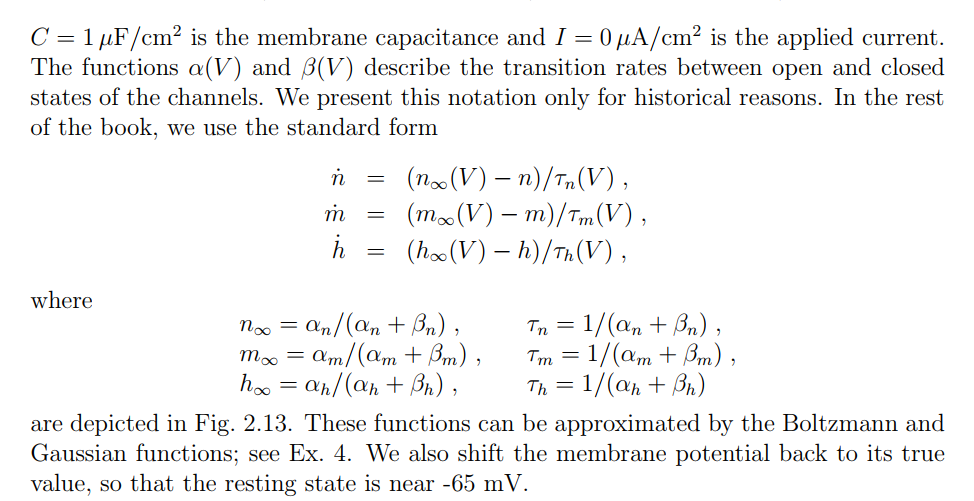

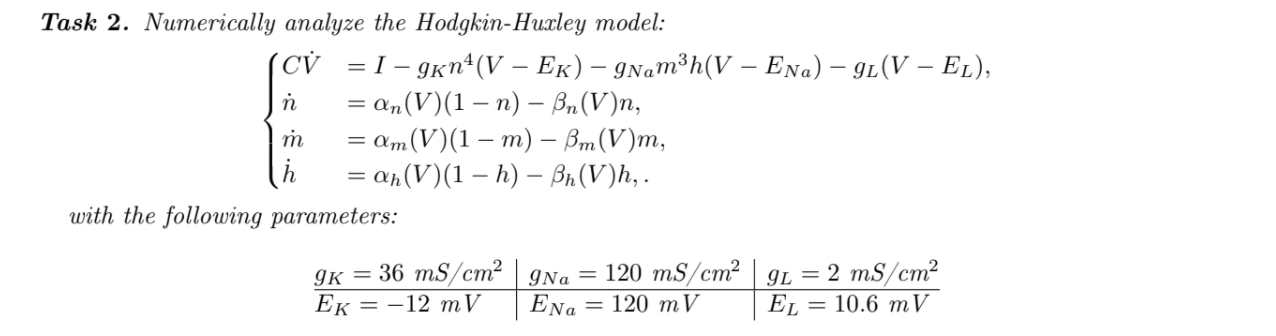g](attachment:b5e1f353-5677-4c5a-a4b2-cf09cd63ee5b.png)
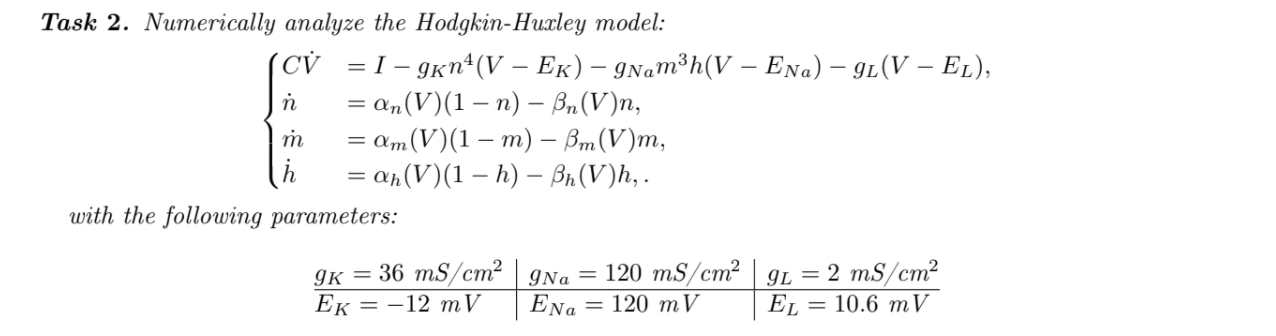

#### 2. HH-Model (Hand-Made)

In [6]:
def HH_original(V, n, m, h, I, C=1, g_K=36, g_Na=120, g_L=2, E_K=-12, E_Na=120, E_L=10.6):
    """
    Hodgkin-Huxley Model
    Gets current values of four variables: V, n, m, h as well as input current I
    Outputs changes in these variables: dV, dn, dm, dh according to HH-equations
    Uses predefined gating functions alpha(V) and beta(V)
    Do not forget, that V is shifted 65mV up, so after calculation it has to be adjusted back
    HH assumes the V_rest = 0 mV
    """
    I_K = g_K * (n ** 4) * (V - E_K)
    I_Na = g_Na * (m ** 3) * h * (V - E_Na)
    I_L = g_L * (V - E_L)
    
    #print(f"K: {I_K}; Na: {I_Na}, L: {I_L}")
    
    dV = (I - I_K - I_Na - I_L)/C
    dn = alpha_n(V) * (1 - n) - beta_n(V) * n
    dm = alpha_m(V) * (1 - m) - beta_m(V) * m
    dh = alpha_h(V) * (1 - h) - beta_h(V) * h 
    return dV, dn, dm, dh


def run_HH(V0, n0, m0, h0, I, timepoints, verbose=False, **HH_kwargs):
    """
    Runs estimation of HH-model using Euler numerical solver.
    Gets initial values, I (AS A LIST OF VALUES), timepoints to be estimated on (same shape as I) and HH model hyperparams
    Returns timecourses of V, n, m, h
    """
    assert len(I) == len(timepoints), "Applied current shape and timepoints shape do not coincide"
    
    # initialize output arrays
    V = np.zeros_like(timepoints)
    n = np.zeros_like(timepoints)
    m = np.zeros_like(timepoints)
    h = np.zeros_like(timepoints)
    
    # set initial values
    V[0], n[0], m[0], h[0] = V0, n0, m0, h0
    
    # infer timestep
    step = timepoints[1] - timepoints[0]
    print(f"Step: {step} ms")
    
    for i in range(1, len(timepoints)):
        
        dV, dn, dm, dh = HH_original(V[i-1], n[i-1], m[i-1], h[i-1], I[i-1], **HH_kwargs)
        
        if verbose: print(f"{i} - dV: {dV:.2f}, dn: {dn:.2f}, dm: {dm:.2f}, dh: {dh:.2f}")
        
        V[i] = V[i-1] + dV * step
        n[i] = n[i-1] + dn * step
        m[i] = m[i-1] + dm * step
        h[i] = h[i-1] + dh * step
        
    return V, n, m, h


def get_initial_values(V0=0):
    n0 = n_inf(V0)
    m0 = m_inf(V0)
    h0 = h_inf(V0)
    print(f"V0: {V0:.2f}, n0: {n0:.2f}, m0: {m0:.2f}, h: {h0:.2f}")
    return np.array([V0, n0, m0, h0])

#### 3. HH-Model 2D-reduction

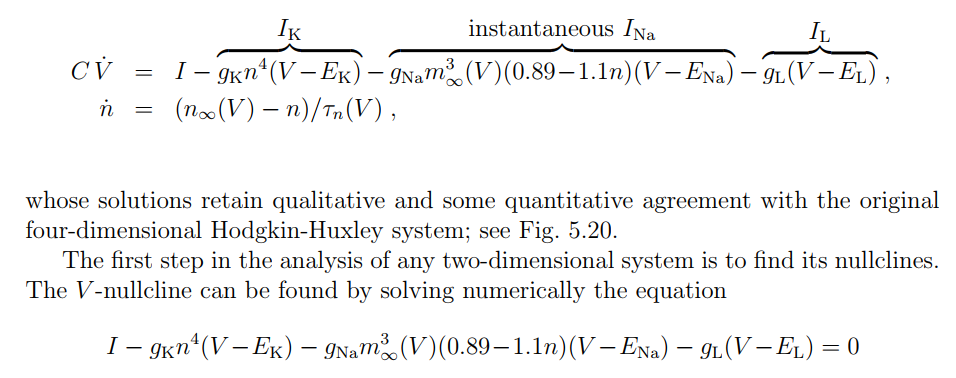

In [7]:
def HH_reduced(y, I, C=1, g_K=36, g_Na=120, g_L=2, E_K=-12, E_Na=120, E_L=10.6):
    """
    Reduced HH-mode
    y = [V, n]
    Return dy = [dV, dn]
    """
    V, n = y
    
    I_K = g_K * (n ** 4) * (V - E_K)
    I_Na = g_Na * (m_inf(V) ** 3) * (0.89 - 1.1 * n) * (V - E_Na)
    I_L = g_L * (V - E_L)
    
    dV = (I - I_K - I_Na - I_L)/C
    dn = (n_inf(V) - n)/tau_n(V)
    
    dy = np.array([dV, dn])
    return dy

##### Vector Field

In [9]:
def get_vector_field(I, Vlim=(-15, 110), nlim=(.05, .95)):
    """
    Returns n_mesh, V_mesh, dn, dv: shape=(len(n_grid), len(V_grid))
    """
    V_grid = np.arange(*Vlim, 3)
    n_grid = np.arange(*nlim, 0.02)

    Y1, Y2 = np.meshgrid(V_grid, n_grid)
    
    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    for i in range(NI):
        for j in range(NJ):
            V = Y1[i, j]
            n = Y2[i, j]
            yprime = HH_reduced([V, n], I)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]
            
    return Y1, Y2, u, v

##### Isoclines

In [ ]:
from scipy.optimize import fsolve

def fV(n, V, I, C, g_K, g_Na, g_L, E_K, E_Na, E_L):
    return I - g_K * n ** 4 * (V - E_K) - g_Na * (m_inf(V) ** 3) * (0.89 - 1.1 * n) * (V - E_Na) - g_L * (V - E_L)

def find_V_isocline(I, V_grid=(-11, 120, 1)):
    Vs = np.arange(*V_grid)
    Vs = Vs[(Vs!=10) & (Vs!=25)]
    ns = []
    for V in Vs:
        args=(V, I, 1, 36, 120, 2, -12, 120, 10.6)
        ns.append(fsolve(fV, x0=0.6, args=args))
        
    return Vs, ns

def find_n_isocline(I, V_grid=(-11, 120, 1)):
    Vs = np.arange(*V_grid)
    Vs = Vs[(Vs!=10) & (Vs!=25)]
    return Vs, n_inf(Vs)

##### Phase portrait

In [163]:
def plot_phase_portrait(I, nlim=(.05, .95), Vlim=(-15, 120), ax=None, normalize=False, scale=True, draw_isoclines=True, **quiver_kwargs):
    
    V, n, dV, dn = get_vector_field(I, nlim=nlim, Vlim=Vlim)
    
    NV, Nn = V.shape
    
    # all vectors will be of unit length
    if normalize:
        for i in range(NV):
            for j in range(Nn):
                dV[i, j] /= (1/2 * np.abs(dV[i, j]))
                dn[i, j] /= (1/2 * np.abs(dn[i, j]))
    if scale:
        dn = dn * 1e4
                 
    ax.quiver(V, n, dV, dn, color='grey', scale=0.45e5, **quiver_kwargs, alpha=0.5)
    
    if draw_isoclines:
        # V-isocline
        Vs, ns = find_V_isocline(I)
        ax.plot(Vs, ns, color='black', label='V-isocline')
        
        Vs, ns = find_n_isocline(I)
        ax.plot(Vs, ns, color='blue', label='n-isocline')
        
    ax.set_ylim(0.1, 0.9)
    ax.set_xlabel("Voltage, mV")
    ax.set_ylabel("n (K-activation variable), a.u.")
    
    ax.legend()
    

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


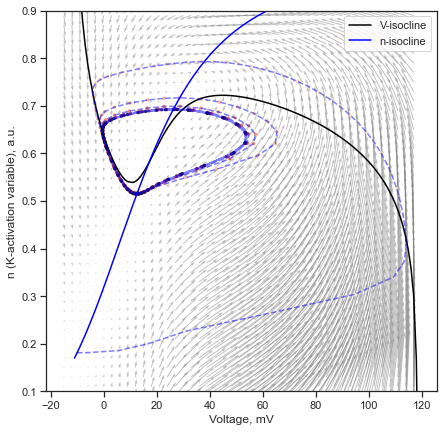

In [164]:
I = 50
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_phase_portrait(I, normalize=False, ax=ax)

I_func = Current()
T = 100
I_func.step((0, T), I)
y0 = get_initial_values(V0=-10)
solver = run_model(y0, T, I_func.func)
plt.scatter(solver.y[0], solver.y[1], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7, s=6)
plt.plot(solver.y[0], solver.y[1], linestyle='--', alpha=0.5, color='blue')

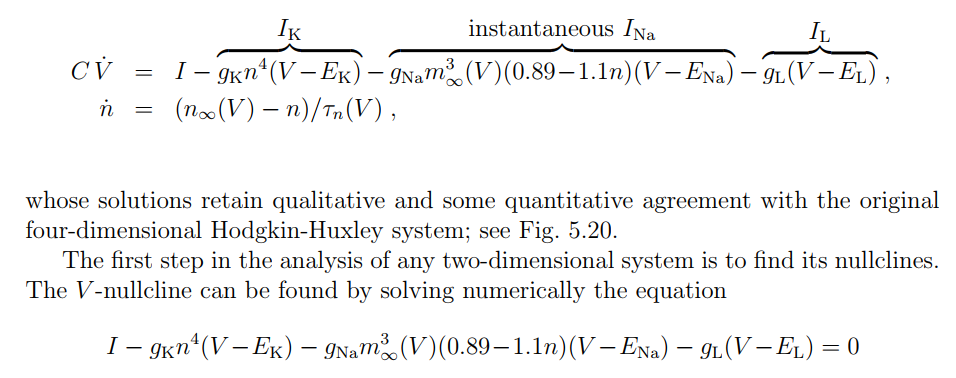

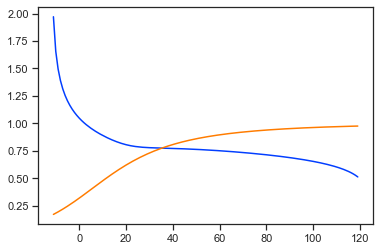

In [97]:


Vs, ns = find_V_isocline(I)
plt.plot(Vs, ns)

Vs, ns = find_n_isocline(I)
plt.plot(Vs, ns)

#### 4. HH-model: Scipy numerical solver

For convenience I will embed default conductance and return current values directly into the F(t, y) function. The only argument 

In [12]:
from scipy.integrate import solve_ivp


def HH_scipy(t, y, I_func):
    
    # setting non-mutable model parameters
    C, g_K, g_Na, g_L, E_K, E_Na, E_L = (1., 36., 120., 2., -12., 120., 10.6)
    
    # dissecting y
    V, n, m, h = y
    
    # calculate ionic currents
    I_K = g_K * (n ** 4) * (V - E_K)
    I_Na = g_Na * (m ** 3) * h * (V - E_Na)
    I_L = g_L * (V - E_L)
    
    ## How to deal with I(t)?
    # We put function as a parameter
    
    # HH-equations
    dV = (I_func(t) - I_K - I_Na - I_L) / C
    dn = alpha_n(V) * (1 - n) - beta_n(V) * n
    dm = alpha_m(V) * (1 - m) - beta_m(V) * m
    dh = alpha_h(V) * (1 - h) - beta_h(V) * h
    
    return np.array([dV, dn, dm, dh])
    


def run_model(y0, T, I_func):
    t_span = [0, T]
    solver = solve_ivp(HH_scipy, t_span, y0, args=(I_func, ))
    return solver

#### 5. Injected Current Class

In [14]:
import numpy as np

class Current:
    
    def __init__(self, func=lambda t: 0):
        self.func = func
    
    
    def step(self, times, I):
        """
        I: amplitude
        times: (t0, t1)
        """
        g = self.func
        f = lambda t: g(t) + I * int(times[0] <= t <= times[1])
        self.func = f
        
        
    def periodic_pulse(self, times, I=100, period=20, pulse_duration=2):
        g = self.func
        assert pulse_duration < period, "Pulse duration must not exceed the period"
        f = lambda t: g(t) + int(times[0] <= t <= times[1]) * I * int(0 <= (t % period) <= pulse_duration)
        self.func = f
        
        
    def monotonous(self, times, I1, I2):
        b = I1
        k = np.tan((I2 - I1)/(times[1] - times[0]))
        g = self.func
        f = lambda t: g(t) + (k * (t - times[0]) + b) * int(times[0] <= t <= times[1])
        self.func = f
        
        
    def plot(self, timepoints, ax=None, **plt_kwargs):
        if ax is None:
            plt.step(timepoints, [self.func(t) for t in timepoints], **plt_kwargs)
        else:
            ax.step(timepoints, [self.func(t) for t in timepoints], **plt_kwargs)
            
            
    def reset(self, times='all'):
        if times == 'all':
            self.func = lambda t: 0
        else:
            g = self.func
            f = lambda t: g(t) * (1 - int(times[0] <= t <= times[1]))
            self.func = f
            
    
    
        

#### 6. HH estimation (V(t)

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


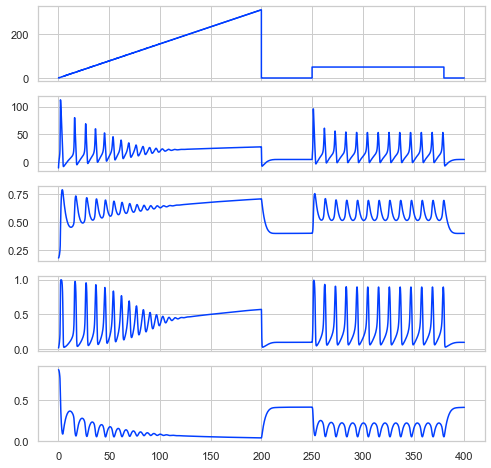

In [213]:
warnings.filterwarnings('ignore')

I = Current()
I.monotonous((0, 200), 0, 200)
#I.periodic_pulse((200, 400), period=16)
I.step((250, 380), 50)


plt.show()

T = 400
y0 = get_initial_values(V0=-10)
solver = run_model(y0, T, I.func)

fig, axes = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

ax = axes[0]
I.plot(solver.t, ax=ax)
ax = axes[1]
ax.plot(solver.t, solver.y[0])
ax = axes[2]
ax.plot(solver.t, solver.y[1])
ax = axes[3]
ax.plot(solver.t, solver.y[2])
ax = axes[4]
ax.plot(solver.t, solver.y[3])
plt.show()

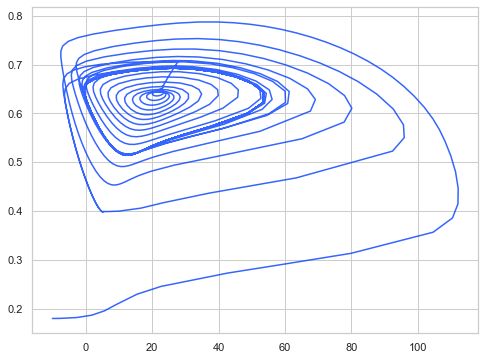

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(solver.y[0], solver.y[1], alpha=0.8)

#### 7. Getting equilibrium value for V

V0: 5.20, n0: 0.40, m0: 0.10, h: 0.41
-----
Equilibrium value of membrane potential 5.196
-----


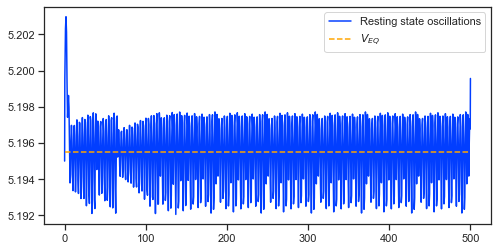

In [135]:
warnings.filterwarnings('ignore')

T = 500
y0 = get_initial_values(V0=5.195)
solver = run_model(y0, T, Current().func)

fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

ax = axes
ax.plot(solver.t, solver.y[0], label="Resting state oscillations")
V_EQ = solver.y[0].mean()
ax.hlines(V_EQ, solver.t[0], solver.t[-1], colors='orange', linestyles='--', label=r"$V_{EQ}$")
ax.legend()
print(f"-----\nEquilibrium value of membrane potential {V_EQ:.3f}\n-----")

Let's find the equilibrium value for V

##### Task progress

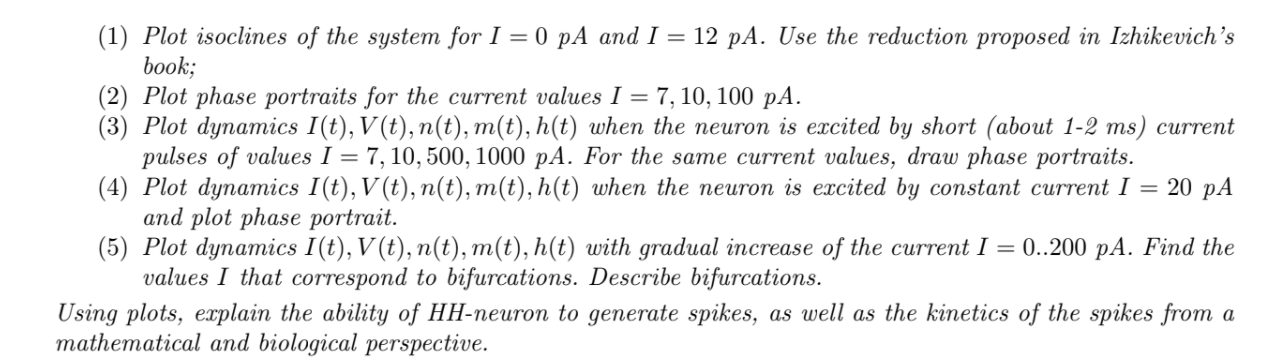

##### Task 1. Isoclines

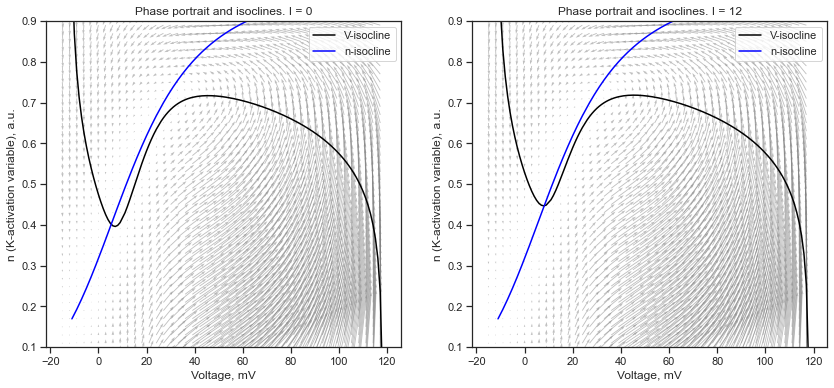

In [165]:
I_list = [0, 12]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i in range(len(I_list)):
    axes[i].set_title(f"Phase portrait and isoclines. I = {I_list[i]}")
    plot_phase_portrait(I_list[i], ax = axes[i], normalize=False, scale=True)
    
plt.savefig('task1_isoclines.pdf')

##### Task 2. Phase portraits

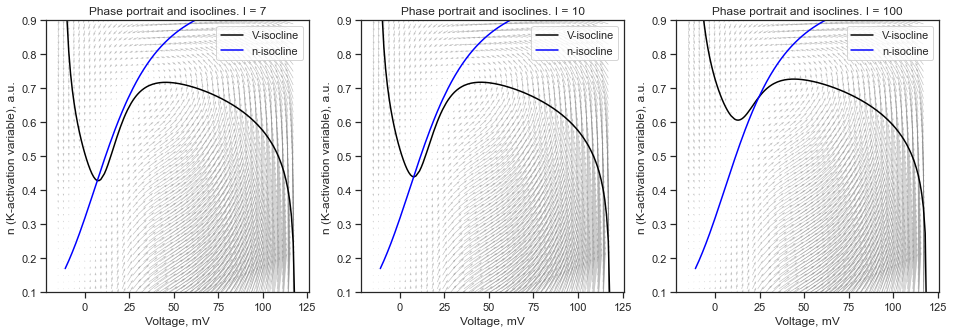

In [167]:
I_list = [7, 10, 100]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(len(I_list)):
    axes[i].set_title(f"Phase portrait and isoclines. I = {I_list[i]}")
    plot_phase_portrait(I_list[i], ax = axes[i], normalize=False, scale=True,)
    
plt.savefig('task2_phase_portraits.pdf')

##### Task 3. Short pulses of current

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


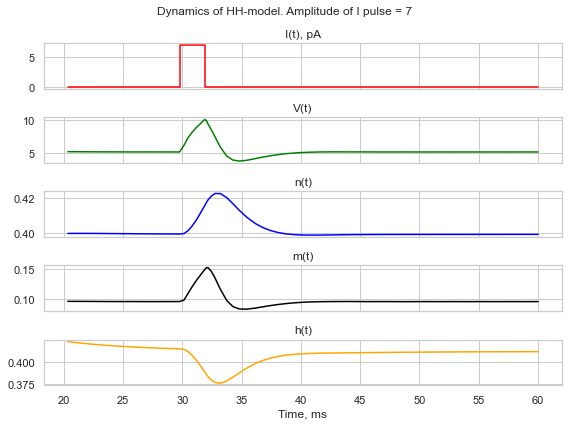

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


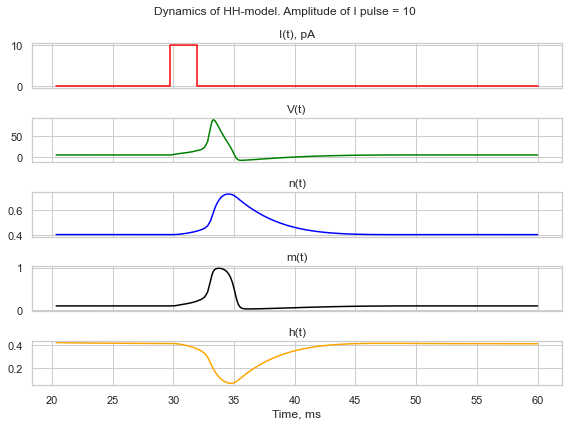

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


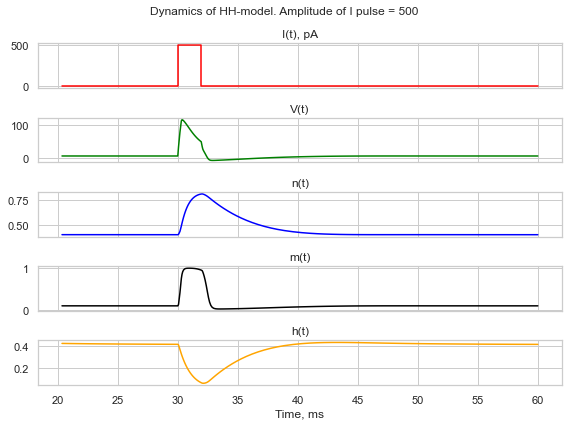

V0: -10.00, n0: 0.18, m0: 0.02, h: 0.87


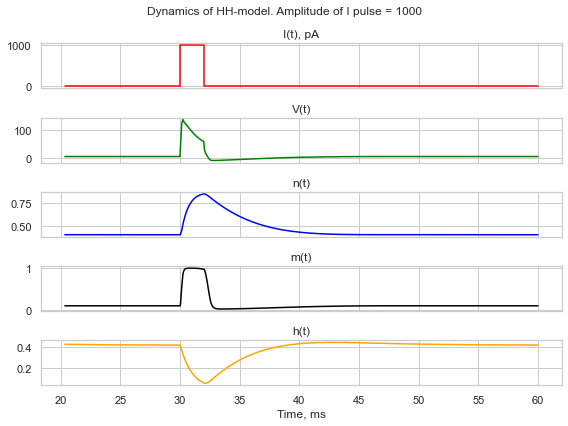

In [180]:
I_list = [7, 10, 500, 1000]

colors = ["red", 'green', 'blue', 'black', 'orange']
titles = ["I(t)", "V(t)", "n(t)", "m(t)", "h(t)"]

seaborn.set_style("whitegrid")

warnings.filterwarnings('ignore')

for i in range(len(I_list)):

    I = Current()
    #I.periodic_pulse((200, 400), period=16)
    I.step((30, 32), I_list[i])

    T = 60
    y0 = get_initial_values(V0=-10)
    solver = run_model(y0, T, I.func)
    
    mask = solver.t > 20

    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    plt.suptitle(f"Dynamics of HH-model. Amplitude of I pulse = {I_list[i]}")

    ax = axes[0]
    ax.set_title("I(t), pA")
    
    I.plot(solver.t[mask], ax=ax, color=colors[0])
    
    for j in range(1, 5):
        ax = axes[j]
        ax.set_title(titles[j])
        ax.plot(solver.t[mask], solver.y[j - 1][mask], color=colors[j])
    ax.set_xlabel("Time, ms")
    
    plt.tight_layout()
    
    plt.savefig(f"figures/task3_dynamics_I{I_list[i]}pA.pdf")
    plt.show()

##### Task 4. Dynamics for constant current I = 20 pA + phase-portrait 

V0: 5.20, n0: 0.40, m0: 0.10, h: 0.41


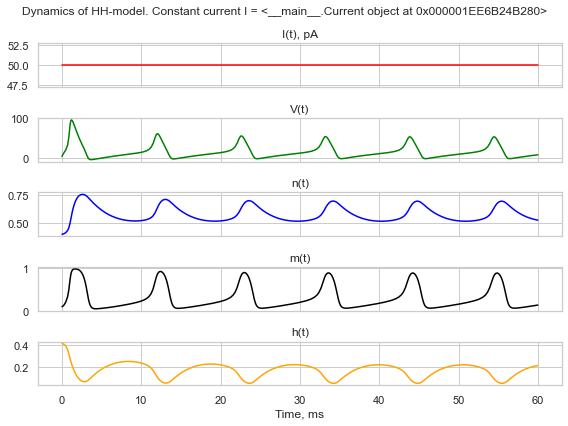

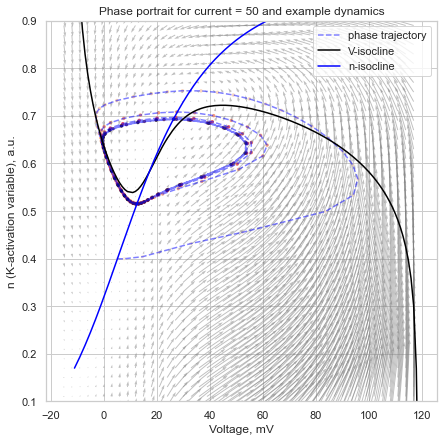

In [196]:
colors = ["red", 'green', 'blue', 'black', 'orange']
titles = ["I(t)", "V(t)", "n(t)", "m(t)", "h(t)"]

I_val = 50
T = 60
I = Current()
I.step((0, T), I_val)

y0 = get_initial_values(V0=V_EQ)
solver = run_model(y0, T, I.func)


fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
plt.suptitle(f"Dynamics of HH-model. Constant current I = {I}")

ax = axes[0]
ax.set_title("I(t), pA")

I.plot(solver.t, ax=ax, color=colors[0])

for j in range(1, 5):
    ax = axes[j]
    ax.set_title(titles[j])
    ax.plot(solver.t, solver.y[j - 1], color=colors[j])
ax.set_xlabel("Time, ms")

plt.tight_layout()

plt.savefig(f"figures/task4_dynamics_constant{I_val}pA.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.set_title(f"Phase portrait for current = {I_val} and example dynamics")
ax.plot(solver.y[0], solver.y[1], linestyle='--', alpha=0.5, color='blue', label='phase trajectory')
ax.scatter(solver.y[0], solver.y[1], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7, s=6)
plot_phase_portrait(I_val, ax=ax)
plt.savefig(f"figures/task4_phase_portrait_constant{I_val}pA.pdf")

##### Task 5. Gradual increase of current. Bifurcations.

V0: 5.20, n0: 0.40, m0: 0.10, h: 0.41
V0: 5.20, n0: 0.40, m0: 0.10, h: 0.41


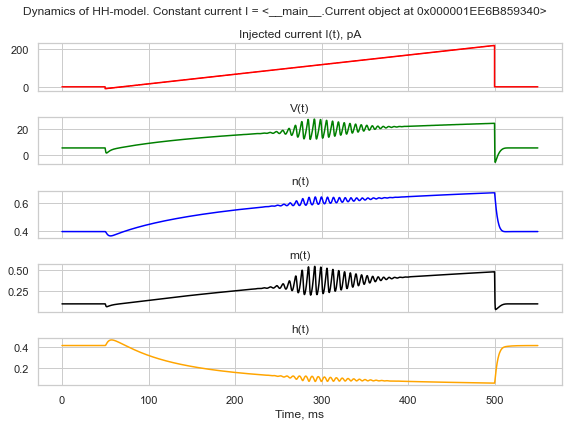

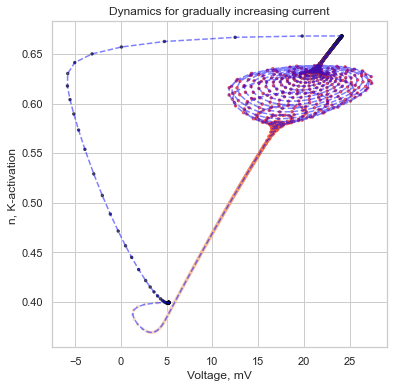

In [201]:
colors = ["red", 'green', 'blue', 'black', 'orange']
titles = ["I(t)", "V(t)", "n(t)", "m(t)", "h(t)"]

I = Current()
I.monotonous((50, 500), -10, 200)

T = 550
y0 = get_initial_values(V0=V_EQ)
solver = run_model(y0, T, I.func)


y0 = get_initial_values(V0=V_EQ)
solver = run_model(y0, T, I.func)


fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
plt.suptitle(f"Dynamics of HH-model. Constant current I = {I}")

ax = axes[0]
ax.set_title("Injected current I(t), pA")

I.plot(solver.t, ax=ax, color=colors[0])

for j in range(1, 5):
    ax = axes[j]
    ax.set_title(titles[j])
    ax.plot(solver.t, solver.y[j - 1], color=colors[j])
ax.set_xlabel("Time, ms")

plt.tight_layout()

plt.savefig(f"figures/task5_dynamics_gradual_increase.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title(f"Dynamics for gradually increasing current")
ax.plot(solver.y[0], solver.y[1], linestyle='--', alpha=0.5, color='blue', label='phase trajectory')
ax.scatter(solver.y[0], solver.y[1], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7, s=6)
#plot_phase_portrait(I_val, ax=ax)
ax.set_xlabel("Voltage, mV")
ax.set_ylabel("n, K-activation ")
plt.savefig(f"figures/task5_dynamics.pdf")

#### 8. Bifurcation time-course

1. Isoclines for I = 0, I = 12
2. Phase portraits for I = 0, 7, 10, 12, 20, 500, 1000

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


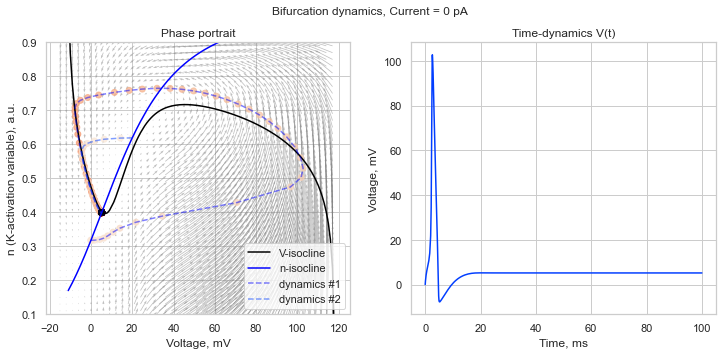

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


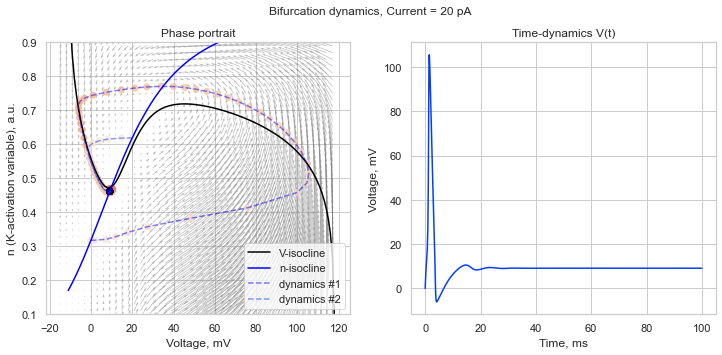

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


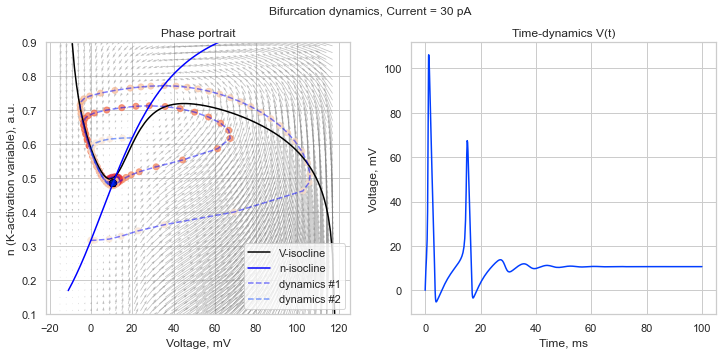

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


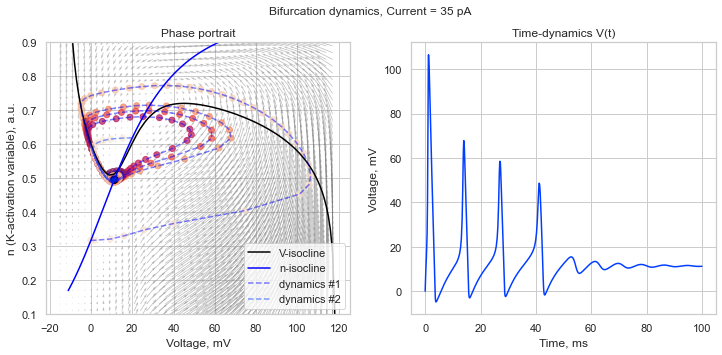

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


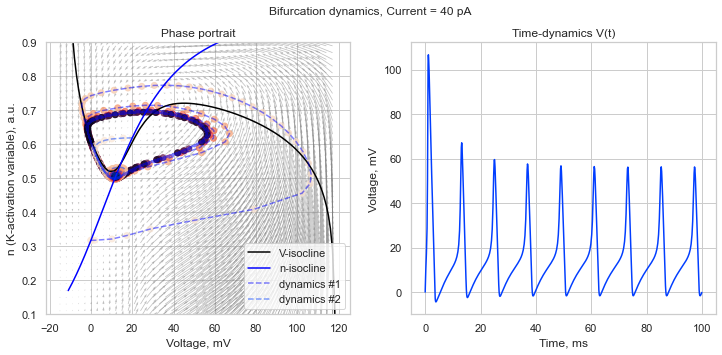

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


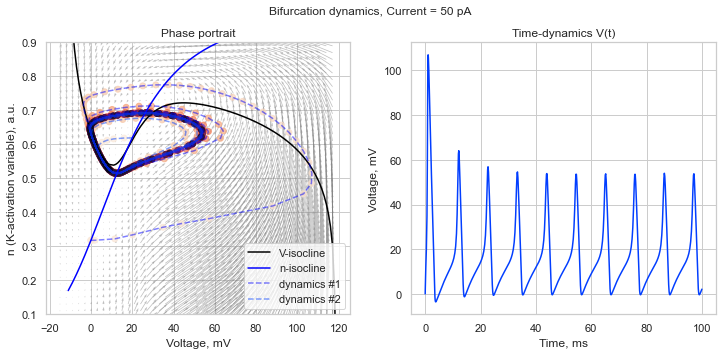

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


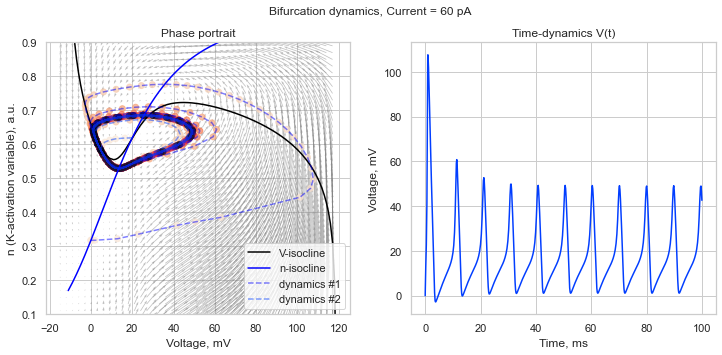

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


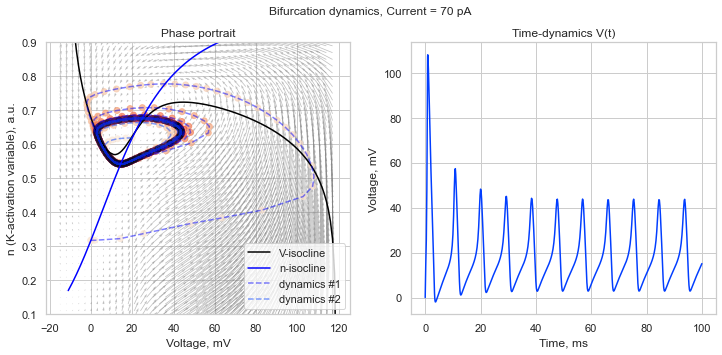

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


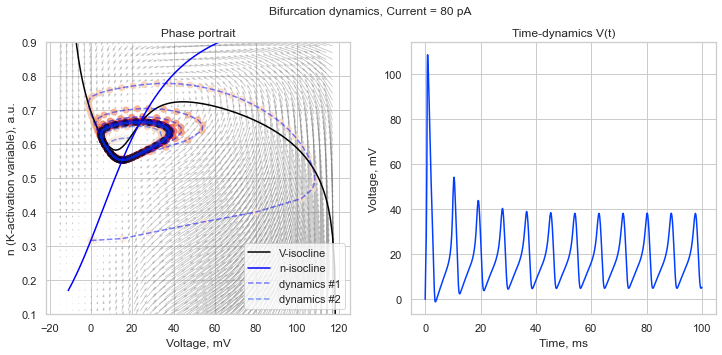

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


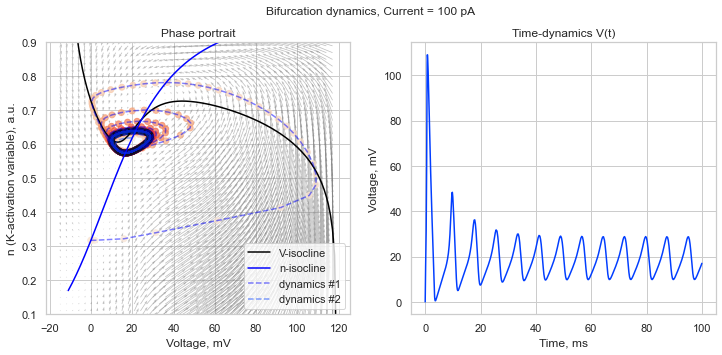

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


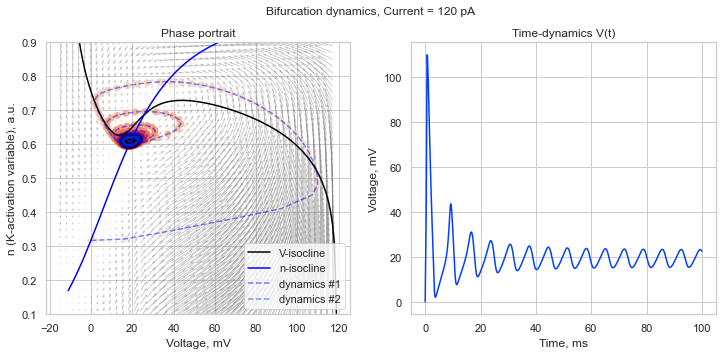

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


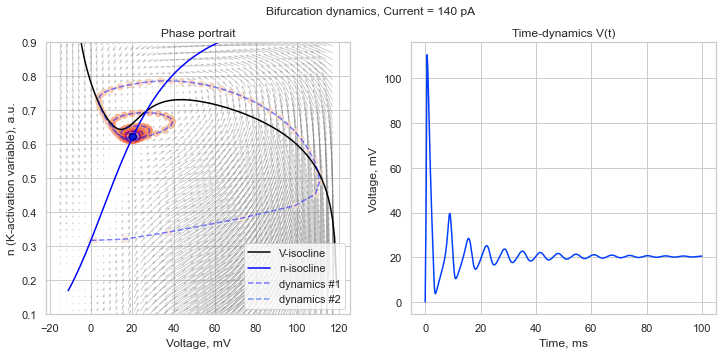

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


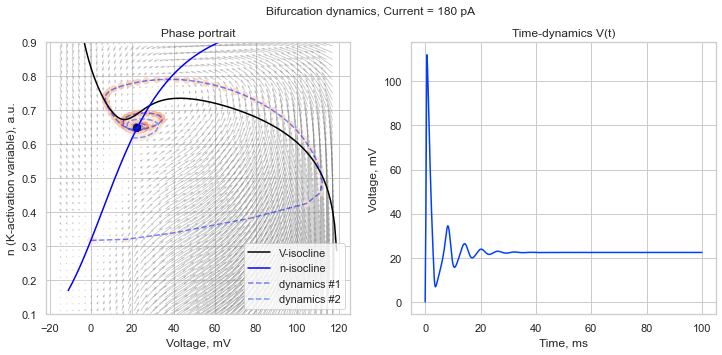

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


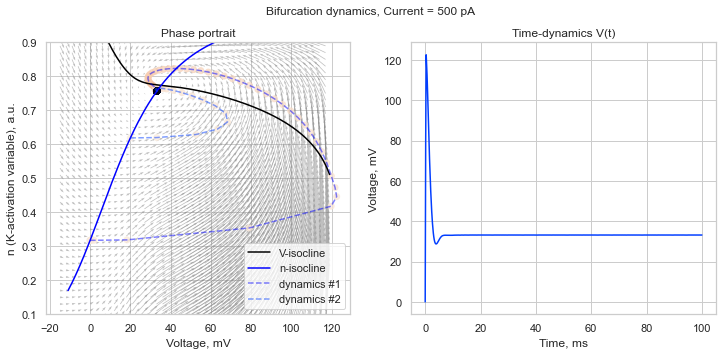

V0: 0.00, n0: 0.32, m0: 0.05, h: 0.60
V0: 20.00, n0: 0.62, m0: 0.37, h: 0.09


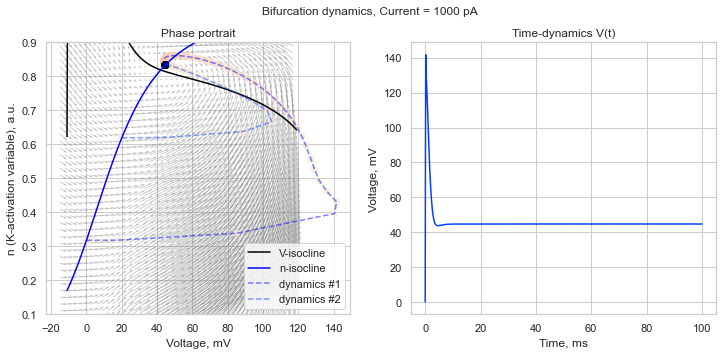

In [212]:
%matplotlib inline
V_grid = np.linspace(-50, 100, 1500)
I_list = [0, 20, 30, 35, 40, 50, 60, 70, 80, 100, 120, 140, 180, 500, 1000]
ylim = (-200, 180)
for I in I_list:
    #print(f"Injected current: {I}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(f"Bifurcation dynamics, Current = {I} pA")
    # dV = np.array([HH_original(V, n_inf(V), m_inf(V), h_inf(V), I, g_L=2) for V in V_grid]) # using n_inf(V) vals as these variables are fast
    
    # 1st - normal 1-dim phase-portrait: (V, dV/dt)
    # ax = axes[0]
    # ax.set_ylim(ylim)
    # ax.plot(V_grid, dV[:, 0])
    # ax.hlines(0, V_grid[0], V_grid[-1], color='black', linestyle='--', label="$$")
    # ax.vlines(V_EQ, ylim[0], ylim[1], color='black', linestyle='--', label=r"$V_{EQ}$")
    #ax.grid()
    
    # 2nd - 2d plot with n and m variables
    ax = axes[0]
    I_func = Current()
    T = 100
    I_func.step((0, T), I)
    
    y0 = get_initial_values(V0=0)
    solver = run_model(y0, T, I_func.func)
    plot_phase_portrait(I, ax=ax)
    ax.set_title("Phase portrait")
    ax.scatter(solver.y[0], solver.y[1], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7)
    ax.plot(solver.y[0], solver.y[1], linestyle='--', alpha=0.5, color='blue', label='dynamics #1')
    ax.grid()
    
    ax = axes[1]
    ax.plot(solver.t, solver.y[0])
    ax.set_title("Time-dynamics V(t)")
    ax.set_xlabel("Time, ms")
    ax.set_ylabel("Voltage, mV")
    
#     y0 = get_initial_values(V0=20)
#     solver = run_model(y0, T, I_func.func)
#     ax = axes[0]
#     ax.scatter(solver.y[0], solver.y[1], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7)
#     ax.plot(solver.y[0], solver.y[1], linestyle='--', alpha=0.5, label='dynamics #2')
#     ax.legend()
    
    plt.savefig(f"figures/task5/task5_bifurcation_dynamics_{I}pA.png", dpi=300)
    plt.show()

V0: -20.00, n0: 0.09, m0: 0.00, h: 0.97
V0: -18.21, n0: 0.10, m0: 0.01, h: 0.96
V0: -16.41, n0: 0.12, m0: 0.01, h: 0.94
V0: -14.62, n0: 0.13, m0: 0.01, h: 0.93
V0: -12.82, n0: 0.15, m0: 0.01, h: 0.91
V0: -11.03, n0: 0.17, m0: 0.01, h: 0.88
V0: -9.23, n0: 0.19, m0: 0.02, h: 0.85
V0: -7.44, n0: 0.21, m0: 0.02, h: 0.81
V0: -5.64, n0: 0.24, m0: 0.03, h: 0.77
V0: -3.85, n0: 0.26, m0: 0.03, h: 0.72
V0: -2.05, n0: 0.29, m0: 0.04, h: 0.67
V0: -0.26, n0: 0.31, m0: 0.05, h: 0.61
V0: 1.54, n0: 0.34, m0: 0.06, h: 0.54
V0: 3.33, n0: 0.37, m0: 0.08, h: 0.48
V0: 5.13, n0: 0.40, m0: 0.09, h: 0.41
V0: 6.92, n0: 0.43, m0: 0.12, h: 0.35
V0: 8.72, n0: 0.46, m0: 0.14, h: 0.30
V0: 10.51, n0: 0.48, m0: 0.17, h: 0.25
V0: 12.31, n0: 0.51, m0: 0.20, h: 0.21
V0: 14.10, n0: 0.54, m0: 0.23, h: 0.17
V0: 15.90, n0: 0.56, m0: 0.27, h: 0.14
V0: 17.69, n0: 0.59, m0: 0.31, h: 0.11
V0: 19.49, n0: 0.61, m0: 0.36, h: 0.09
V0: 21.28, n0: 0.64, m0: 0.40, h: 0.08
V0: 23.08, n0: 0.66, m0: 0.45, h: 0.06
V0: 24.87, n0: 0.68, m0:

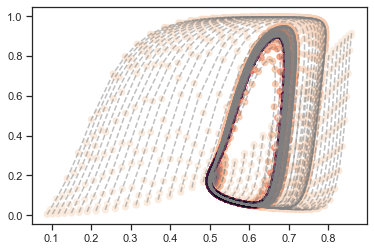

In [30]:
V_grid = np.linspace(-20, 50, 40)
I = 40

for V0 in V_grid:
    I_func = Current()
    T = 100
    I_func.step((0, T), I)
    y0 = get_initial_values(V0=V0)
    solver = run_model(y0, T, I_func.func)
    plt.scatter(solver.y[1], solver.y[2], c=np.arange(len(solver.y[1]), 0, -1), alpha=0.7)
    plt.plot(solver.y[1], solver.y[2], linestyle='--', alpha=0.5, color='grey')
    
plt.show()

In [23]:
n_inf(10)

nan

#### 9. (2.5) Gradual increase of current



V0: 5.20, n0: 0.40, m0: 0.10, h: 0.41


Text(0, 0.5, 'Voltage, mV')

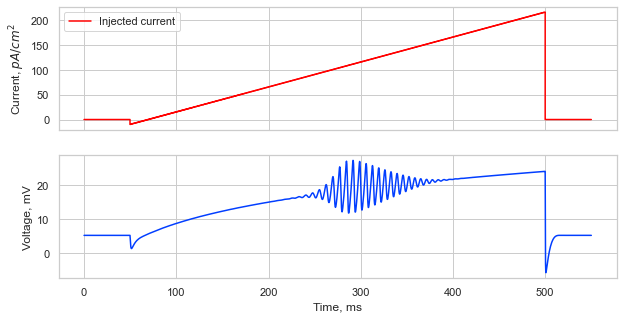

In [36]:
%matplotlib inline
I = Current()
I.monotonous((50, 500), -10, 200)

T = 550
y0 = get_initial_values(V0=V_EQ)
solver = run_model(y0, T, I.func)

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
I.plot(solver.t, ax=ax, label='Injected current', color='red')
ax.legend()
ax.set_ylabel(r"Current, $pA/cm^2$")

ax = axes[1]
ax.plot(solver.t, solver.y[0], label='HH solution')
ax.set_xlabel("Time, ms")
ax.set_ylabel("Voltage, mV")

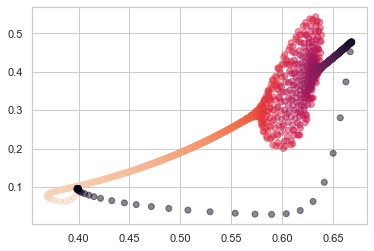

In [38]:
plt.scatter(solver.y[1], solver.y[2], c=np.arange(len(solver.y[1]), 0, -1), marker='o', alpha=0.5)

- Bifurcations are clearly seen at around 60 pA and 150 pA
- What kind of bifurcations? Who knows. Phase portraits basically showed nothing.

Check out supercritical Andronov-Hopf bifurcation (p.122 (132 in pdf))